# init

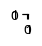

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

## reloading datasets

In [2]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [3]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [4]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [5]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [34]:
cedar_aligned['len_core_mut'] = cedar_aligned['core_mut'].apply(len)
cedar_aligned.len_core_mut.unique()

array([9])

In [306]:
encode_batch_weighted(sample, ics_shannon, None, 9, 'onehot', None, 'core_mut')

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9169,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.3213],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9634,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9604, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [315]:
weighted_sequences = encode_batch_weighted(sample, ics_dict=ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut')
# Here added a special argument "true_lens" where we provide the true lengths
freqs = batch_compute_frequency(weighted_sequences.numpy(), true_lens=9)
extra_freqs = batch_find_extra_aa(core_seqs, icore_seqs)
summed = np.add(freqs,extra_freqs)
summed[4:]

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


array([[0.10369743, 0.        , 0.        , 0.10237203, 0.        ,
        0.09803756, 0.        , 0.        , 0.        , 0.19956324,
        0.0370485 , 0.        , 0.        , 0.        , 0.09752864,
        0.10269237, 0.        , 0.        , 0.        , 0.04814585],
       [0.10457226, 0.        , 0.        , 0.08788767, 0.        ,
        0.        , 0.10608057, 0.10462533, 0.10660405, 0.10613236,
        0.10538305, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07088175, 0.        , 0.        , 0.01572936]],
      dtype=float32)

In [325]:
x,y = get_dataset(sample, ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut', hla_col='HLA', target_col='agg_label',
                  rank_col='EL_rank_mut', mask=False, invert=False, add_rank=True, add_aaprop=False, remove_pep=False, icore_bulge=True,
                  core_col='core_mut', icore_col='icore_mut')

True
here
before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


# Training a model with only rank and all weightings

In [10]:
cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / cedar_aligned['EL_rank_wt_aligned']
prime_aligned['ratio_rank'] = prime_aligned['EL_rank_mut'] / prime_aligned['EL_rank_wt_aligned']
nepdb_aligned['ratio_rank'] = nepdb_aligned['EL_rank_mut'] / nepdb_aligned['EL_rank_wt_aligned']
cedar_aligned['ratio_rank_copy'] = cedar_aligned['ratio_rank']
prime_aligned['ratio_rank_copy'] = prime_aligned['ratio_rank']
nepdb_aligned['ratio_rank_copy'] = nepdb_aligned['ratio_rank']

In [ ]:
checkcols = ['HLA','agg_label','Peptide','wild_type', 'icore_mut', 'icore_wt_aligned', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank']
idx = [787, 2111, 2387, 66, 2049, 319, 675, 123, 2434, 2818]
for alpha in [.01, .1, .5, 0.9, 1, 10]:
    for top in [True, False]:
        if top:
            cedar_aligned['ratio_rank'] = (cedar_aligned['EL_rank_mut']+alpha) / cedar_aligned['EL_rank_wt_aligned']
        else:
            cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / (cedar_aligned['EL_rank_wt_aligned']+alpha)
        print(f'Top: {top},\t Alpha: {alpha}')
        display(cedar_aligned.loc[idx,checkcols])

Top: True,	 Alpha: 0.01


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.478844
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.068504
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.329643
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.080989
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.049856
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,1.949609
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,1.121412
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,1.626359
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,1.336428
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,3.456583


Top: False,	 Alpha: 0.01


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.476937
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.068301
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.252607
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.078293
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.049510
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,1.910396
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,1.101571
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,1.312201
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,1.215432
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,2.481400


Top: True,	 Alpha: 0.1


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.490464
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.070214
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.883149
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.103493
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.052820
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,2.070870
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,1.206382
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,2.849185
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,1.827963
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,5.977591


Top: False,	 Alpha: 0.1


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.471465
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.068184
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.166032
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.076574
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.049364
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,1.706246
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,1.016046
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,0.631912
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,0.829036
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,0.835667


Top: True,	 Alpha: 0.5


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.542113
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.077812
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,3.343173
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.203511
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.065993
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,2.609809
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,1.584026
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,8.283967
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,4.012561
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,17.182073


Top: False,	 Alpha: 0.5


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.448591
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.067671
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.065801
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.069766
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.048724
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,1.156819
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,0.755387
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,0.191248
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,0.343581
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,0.211686


Top: True,	 Alpha: 0.9


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.593761
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.085410
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,5.803198
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.303528
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.079167
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,3.148747
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,1.961669
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,13.718750
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,6.197160
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,28.386555


Top: False,	 Alpha: 0.9


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.427834
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.067166
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.041031
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.064070
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.048101
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,0.875046
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,0.601164
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,0.112675
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,0.216693
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,0.121193


Top: True,	 Alpha: 1


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.606673
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.087310
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,6.418204
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.328532
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.082461
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,3.283482
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,2.056080
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,15.077446
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,6.743310
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,31.187675


Top: False,	 Alpha: 1


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.422942
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.067040
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.037502
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.062789
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.047947
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,0.824819
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,0.571970
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,0.102180
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,0.198377
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,0.109491


Top: True,	 Alpha: 10


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,1.768758
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.258270
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,61.768758
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,2.578926
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.378868
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,15.409593
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,10.553059
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,137.360054
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,55.896778
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,283.288515


Top: False,	 Alpha: 10


,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,ratio_rank
787,HLA-A0201,0,GTAWLEWWHV,GTAWLEWRHV,TAWLEWWHV,TAWLEWRHV,3.6985,7.7447,0.208428
2111,HLA-A3001,0,RTGKAAGLL,PTGKAAGLL,RTGKAAGLL,PTGKAAGLL,3.5963,52.6437,0.057409
2387,HLA-B4001,1,SSEIISFKSL,SSEIISFKSM,SEIISFKSL,SEIISFKSM,0.0436,0.1626,0.004290
66,HLA-A0201,1,ALFALLEIL,ALFALLEIP,ALFALLEIL,ALFALLEIP,0.3139,3.9993,0.022423
2049,HLA-A0201,0,RMHTGEKPYV,RNHTGEKPYV,RMHTGEKPYV,RNHTGEKPYV,1.5038,30.3636,0.037256
319,HLA-B3501,0,DPILPELTRLL,DPIPPELTRLL,DPILPELTRL,DPIPPELTRL,1.4370,0.7422,0.133771
675,HLA-A2402,0,FYFFHETRQY,FYFFHGTRQY,YFFHETRQY,YFFHGTRQY,1.1778,1.0592,0.106500
123,HLA-A0301,0,AMHGRKIMGK,AMNGRKIMGK,AMHGRKIMGK,AMNGRKIMGK,0.1097,0.0736,0.010890
2434,HLA-A0301,0,SVIVRTLSGK,SVIVRTPSGK,VIVRTLSGK,VIVRTPSGK,0.2347,0.1831,0.023048
2818,HLA-A0206,0,WQLEFLQPL,RQLEFLQPL,WQLEFLQPL,RQLEFLQPL,0.1134,0.0357,0.011300


In [52]:
cedar_aligned[['ratio_rank_copy', 'test']].describe(percentiles = [.1, .25, .5, .75, .8, .9,.95,.99])

,ratio_rank_copy,test
count,3033.000000,3033.000000
mean,1.101957,0.904523
std,5.339652,8.766335
min,0.000607,0.000000
10%,0.048137,0.005376
25%,0.266667,0.035388
50%,0.742434,0.186434
75%,1.120557,0.617475
80%,1.290221,0.838521
90%,1.889845,1.640599


In [ ]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.bootstrap import bootstrap_eval
from sklearn.ensemble import RandomForestClassifier

odir = '../output/230320_ratioranks/'
for d in [odir, odir+'bootstrapping/', odir+'raw/']:
    os.makedirs(d, exist_ok=True)
    
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='icore_mut', 
                       hla_col='HLA', target_col='agg_label', rank_col='EL_rank_mut',
                       mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score','ratio_rank'])

results = []
for alpha in ['None', 'Norm', .01, .1, .5, 1, 10]:
    if alpha =='None':
        cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
        prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
        nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']), axis=1)
    elif alpha =='Norm':
        cedar_aligned['ratio_rank'] = cedar_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
        prime_aligned['ratio_rank'] = prime_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
        nepdb_aligned['ratio_rank'] = nepdb_aligned.apply(lambda x: (x['EL_rank_mut'] / x['EL_rank_wt_aligned']) * abs(x['EL_rank_mut']-x['EL_rank_wt_aligned']), axis=1)
    elif type(alpha)==int or type(alpha)==float:
        cedar_aligned['ratio_rank'] = cedar_aligned['EL_rank_mut'] / (cedar_aligned['EL_rank_wt_aligned']+alpha)
        prime_aligned['ratio_rank'] = prime_aligned['EL_rank_mut'] / (prime_aligned['EL_rank_wt_aligned']+alpha)
        nepdb_aligned['ratio_rank'] = nepdb_aligned['EL_rank_mut'] / (nepdb_aligned['EL_rank_wt_aligned']+alpha)
    
    filename = f'onehot_None_icore_mut_EL_rank_mut_GeneralModel_alpha{alpha:0e}' if type(alpha)!=str else f'onehot_None_icore_mut_EL_rank_mut_GeneralModel_alpha{alpha}'
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                           max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                                ics_dict=None,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['rank'] + ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']
    # Saving Feature importances as dataframe
    df_fi = pd.DataFrame(fi, index=fn).T
    df_fi.to_csv(f'{odir}raw/featimps_{filename}.csv', index=False)
    for evalset, evalname in zip([cedar_aligned, prime_aligned, nepdb_aligned],
                             ['CEDAR', 'PRIME', 'NEPDB']):
        # FULLY FILTERED + Mean_pred
        if not evalset.equals(cedar_aligned):
            evalset = evalset.query('Peptide not in @cedar_aligned.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                   trained_models, None,
                                                   cedar_aligned,
                                                   encoding_kwargs, concatenated=False,
                                                   only_concat=False)
        p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
        preds.to_csv(f'{odir}raw/{evalname}_preds_{filename}.csv', index=False, columns=checkcols+[p_col])
        
        bootstrapped_df, _ = bootstrap_eval(preds[p_col].values, preds['agg_label'].values, n_jobs=8, auc01=True)
        bootstrapped_df['Model']='General Model'
        bootstrapped_df['Ratio_Alpha'] = alpha
        bootstrapped_df['evalset'] = evalname
        bootstrapped_df.to_csv(f'{odir}bootstrapping/{evalname}_bootstrapped_df_{filename}.csv')
        results.append(bootstrapped_df)

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}
{'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'seq_col': 'icore_mut', 'hla_col': 'HLA', 'target_col': 'agg_label', 'rank_col': 'EL_rank_mut', 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']}


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]